In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
import sklearn.metrics as metrics
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import *
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


Using TensorFlow backend.


In [2]:
df=pd.read_csv("data/bank-additional-full.csv",sep=";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
#X랑 y 나누기 
y=df['y']
X=df.drop(columns=['y'])
y

0         no
1         no
2         no
3         no
4         no
        ... 
41183    yes
41184     no
41185     no
41186    yes
41187     no
Name: y, Length: 41188, dtype: object

In [4]:
#split the dataset into training & testing set
def split(X,y,test_size):
    x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=test_size,random_state=0)
    return x_train, x_test, y_train, y_test

In [5]:
#df 중에서 원하는 columns만 one_hot encoding
def onehotEncoding(df,columns):
    onehot=pd.get_dummies(df, prefix=columns)
    return onehot

In [6]:
def labelEncoding(df, columns):
    
    # columns가 y인경우에는 시리즈 형태
    if len(columns)==1 and columns=="y":
        labelX=preprocessing.LabelEncoder()
        df=labelX.fit_transform(df)
    else:
        for i in columns:
            labelX=preprocessing.LabelEncoder()
            df.loc[:,i]=labelX.fit_transform(df.loc[:,i])
    return df

In [7]:
#solver: liblinear, lbfgs, sag
def runLogistic(x_train,x_test,y_train,y_test,param_gird):
    
    logistic=LogisticRegression()
    grid=GridSearchCV(logistic,param_gird,cv=3,scoring='accuracy')
    grid.fit(x_train,y_train)
    param=grid.best_params_
    
    
    clf=LogisticRegression(solver=param['solver'],max_iter=param['max_iter'])
    clf.fit(x_train,y_train)
    score=clf.score(x_test,y_test)
    predict=clf.predict(x_test)
    print(classification_report(y_test, predict, target_names=['N', 'Y']))
    f1=metrics.f1_score(y_test,predict)
    
    return f1, score

In [8]:
#penalty: l1,l2,elasticnet
# run SGDClassifier
def runSGDClassifier(x_train,x_test,y_train,y_test,loss,max_iter,penalty):
    if loss=="logistic":
        loss="log"
    clf=SGDClassifier(loss=loss, penalty=penalty,max_iter=max_iter)
    clf.fit(x_train,y_train)
    predict=clf.predict(x_test)
    score=clf.score(x_test,y_test)
    recall=metrics.f1_score(y_test,predict)
    return recall, score

In [9]:
#kernel "linear","rbf","sigmoid","poly"
def runSVM(x_train,x_test,y_train,y_test,param_grid):
    
     
    sv=svm.SVC()
    grid=GridSearchCV(sv,param_grid,cv=3,scoring='accuracy')
    grid.fit(x_train,y_train)
    
    param=grid.best_params_
    clf=svm.SVC(C=param['C'],kernel=param['kernel'],gamma=param['gamma'])
    
    
    """
    clf=svm.SVC(C=C,kernel=kernel,gamma=gamma)
    """
    clf.fit(x_train,y_train)
    score=clf.score(x_test,y_test)
    predict=clf.predict(x_test)
    print(classification_report(y_test, predict, target_names=['N', 'Y']))
    f1=metrics.f1_score(y_test,predict)
    return f1, score

In [10]:
def runNB(x_train,x_test,y_train,y_test,param_grid):
    nb=GaussianNB()
    grid=GridSearchCV(nb,param_grid,cv=3,scoring='accuracy')
    grid.fit(x_train,y_train)
    
    param=grid.best_params_
    
    clf=GaussianNB(var_smoothing=param["var_smoothing"])
    clf.fit(x_train,y_train)
    score=clf.score(x_test,y_test)
    predict=clf.predict(x_test)
    print(classification_report(y_test, predict, target_names=['N', 'Y']))
    f1=metrics.f1_score(y_test,predict)
    return f1, score

In [11]:
def randomUnderSampling(X,y):
    rus = RandomUnderSampler(random_state=0)
    rus.fit(X,y)
    X_resampled, y_resampled = rus.fit_resample(X, y)
    return X_resampled, y_resampled

In [12]:
def randomOverSampling(X,y):
    ros = RandomOverSampler(random_state=0)
    ros.fit(X, y)
    X_resampled, y_resampled = ros.fit_resample(X, y)
    return x_resampled, y_resampled

In [13]:
#카테고리컬 데이터 뽑는거
object_feature = [col for col in X.columns if X[col].dtypes == 'object' ]

#카테고릴컬 onehot encoding , 타겟은 라벨 인코딩
X=onehotEncoding(X,object_feature)
y=labelEncoding(y,"y")

In [41]:
probs = []
f1s = []
name = []
param_logistic={"solver":["liblinear","lbfgs","sag"], "max_iter" :[50,100,200]}
param_svm={"kernel":["linear","rbf","sigmoid"], "gamma" :[10,100] ,"C":[0.1,1,10]}
param_nb={'var_smoothing':np.logspace(0,-9,num=10)}
x_train,x_test,y_train,y_test=split(X,y,0.3)

In [42]:
#여기서 먼저일단 accuracy 결과만 보여주고, 너무 높게 나왓다 ,, 그래서 그 f1-score  혹은 recall 보니까 1일때
#어쩌구 저쩌구,,, 그래서 샘플링 해서 사용했다! 이러면 될듯
f1,accuracy=runLogistic(x_train,x_test,y_train,y_test,param_logistic)
print(f1, accuracy)


              precision    recall  f1-score   support

           N       0.93      0.97      0.95     10969
           Y       0.67      0.41      0.51      1388

    accuracy                           0.91     12357
   macro avg       0.80      0.69      0.73     12357
weighted avg       0.90      0.91      0.90     12357

0.511814534106108 0.9113862588006798


In [43]:
#svm!!
"""
f1,accuracy=runSVM(x_train,x_test,y_train,y_test,param_svm)
print(f1, accuracy)
"""

'\nf1,accuracy=runSVM(x_train,x_test,y_train,y_test,param_svm)\nprint(f1, accuracy)\n'

In [44]:
f1,accuracy=runNB(x_train,x_test,y_train,y_test,param_nb)

print(f1, accuracy)

              precision    recall  f1-score   support

           N       0.93      0.97      0.95     10969
           Y       0.62      0.40      0.49      1388

    accuracy                           0.90     12357
   macro avg       0.77      0.69      0.72     12357
weighted avg       0.89      0.90      0.90     12357

0.48738033072236736 0.9046694181435624


In [45]:
x_sam,y_sam=randomUnderSampling(X,y)
x_sam_train,x_sam_test,y_sam_train,y_sam_test=split(x_sam,y_sam,0.3)
f1,accuracy=runLogistic(x_sam_train,x_sam_test,y_sam_train,y_sam_test,param_logistic)
print(f1, accuracy)
probs.append(accuracy)
f1s.append(f1)
name.append('Logistic')

              precision    recall  f1-score   support

           N       0.88      0.86      0.87      1393
           Y       0.86      0.89      0.87      1391

    accuracy                           0.87      2784
   macro avg       0.87      0.87      0.87      2784
weighted avg       0.87      0.87      0.87      2784

0.8749557208643288 0.8732040229885057


In [46]:
f1,accuracy=runNB(x_sam_train,x_sam_test,y_sam_train,y_sam_test,param_nb)
print(f1, accuracy)
probs.append(accuracy)
f1s.append(f1)
name.append('NB')

              precision    recall  f1-score   support

           N       0.78      0.88      0.83      1393
           Y       0.86      0.75      0.81      1391

    accuracy                           0.82      2784
   macro avg       0.82      0.82      0.82      2784
weighted avg       0.82      0.82      0.82      2784

0.805065234075211 0.8175287356321839


In [47]:
#svm 일단 주석 처리
"""
f1,accuracy=runSVM(x_sam_train,x_sam_test,y_sam_train,y_sam_test,param_svm)
print(f1, accuracy)
"""

'\nf1,accuracy=runSVM(x_sam_train,x_sam_test,y_sam_train,y_sam_test,param_svm)\nprint(f1, accuracy)\n'

In [48]:
# SVM 돌리면 바꿈
probs.append(0.5)
f1s.append(0.5)
name.append('SVM')

In [49]:
print(runSGDClassifier(x_train,x_test,y_train,y_test,"logistic",5,"l1"))
print(runSGDClassifier(x_train,x_test,y_train,y_test,"logistic",5,"l2"))
print(runSGDClassifier(x_train,x_test,y_train,y_test,"logistic",5,"elasticnet"))
f1, accuracy = runSGDClassifier(x_train,x_test,y_train,y_test,"logistic",5,"l1")
probs.append(accuracy)
f1s.append(f1)
name.append('SGD&l1')

f1, accuracy = runSGDClassifier(x_train,x_test,y_train,y_test,"logistic",5,"l2")
probs.append(accuracy)
f1s.append(f1)
name.append('SGD&l2')

f1, accuracy = runSGDClassifier(x_train,x_test,y_train,y_test,"logistic",5,"elasticnet")
probs.append(accuracy)
f1s.append(f1)
name.append('SGD&elastic')

(0.5246963562753036, 0.8574896819616412)
(0.4043308484203052, 0.7284130452375172)
(0.032280701754385965, 0.8884033341425912)


In [50]:
sm=SMOTE(ratio="auto",kind="regular")
#X_samp, y_samp = TomekLinks(random_state=0).fit_sample(x_train, y_train)
X_samp, y_samp = SMOTE(random_state=4).fit_sample(x_train, y_train)

In [51]:
print(probs)
print(f1s)
print(name)

[0.8732040229885057, 0.8175287356321839, 0.5, 0.9032127539046694, 0.8914785142024764, 0.9058023792182569]
[0.8749557208643288, 0.805065234075211, 0.5, 0.5385802469135803, 0.12638436482084692, 0.43930635838150284]
['Logistic', 'NB', 'SVM', 'SGD&l1', 'SGD&l2', 'SGD&elastic']


In [52]:
def barPlot(probs, name):
    sns.barplot(name, probs, alpha=0.4)
    plt.show()

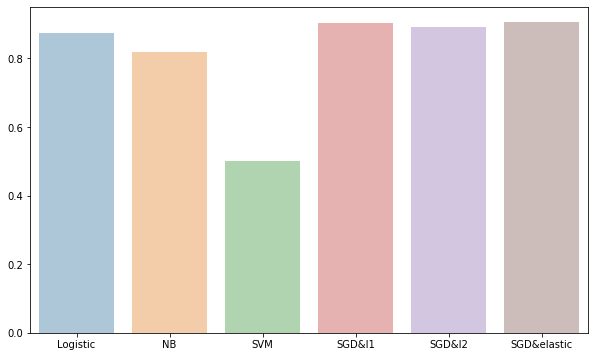

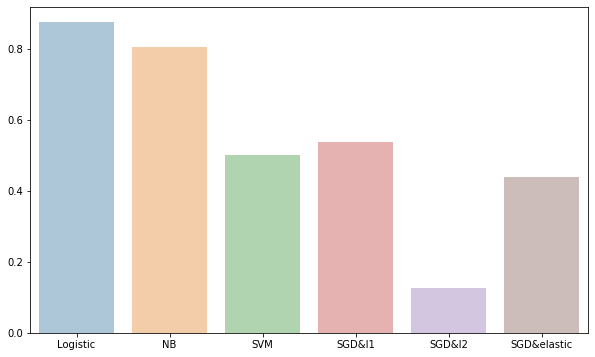

In [55]:
plt.figure(figsize = (10,6))
barPlot(probs, name)
plt.figure(figsize = (10,6))
barPlot(f1s, name)